In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Загрузка данных
try:
    data = pd.read_csv('C:/Medical Waste/Taraz_rotes.csv')
except FileNotFoundError:
    print("Ошибка: файл 'Taraz_Routes.csv' не найден. Проверьте путь.")
    exit()

# Подготовка структуры данных (аналог struct в MATLAB)
TrackingData = namedtuple('TrackingData', ['latitude', 'longitude', 'speed', 'timestamp'])
tracking_data = [
    TrackingData(
        latitude=data.latitude[i],
        longitude=data.longitude[i],
        speed=data.speed[i],
        timestamp=data.timestamp[i]
    )
    for i in range(len(data))
]
speeds = np.array([td.speed for td in tracking_data])

In [22]:
speed_threshold = 1.0
is_stationary = speeds < speed_threshold

current_cluster = []
all_clusters = [] # Список списков индексов

for i in range(len(is_stationary)):
    if is_stationary[i]:
        current_cluster.append(i)
    else:
        if len(current_cluster) >= 3:
            all_clusters.append(current_cluster)
        current_cluster = []

# Обработка последнего кластера
if len(current_cluster) >= 3:
    all_clusters.append(current_cluster)
    
print(f'Найдено {len(all_clusters)} стационарных кластеров с ≥ 3 точками')

Найдено 20 стационарных кластеров с ≥ 3 точками


In [23]:
R = 6371000 
all_errors = []
cluster_stats = []

for c_id, idxs in enumerate(all_clusters):
    lats = np.array([tracking_data[i].latitude for i in idxs])
    lngs = np.array([tracking_data[i].longitude for i in idxs])

    mean_lat = np.mean(lats)
    mean_lng = np.mean(lngs)

    # Расчет ошибок по формуле гаверсинуса (как в MATLAB)
    errs = np.zeros(len(idxs))
    for k in range(len(idxs)):
        lat = lats[k]
        lng = lngs[k]
        dLat = np.deg2rad(lat - mean_lat)
        dLng = np.deg2rad(lng - mean_lng)
        a = np.sin(dLat/2)**2 + np.cos(np.deg2rad(mean_lat)) * np.cos(np.deg2rad(lat)) * np.sin(dLng/2)**2
        c_val = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        errs[k] = R * c_val
        
    all_errors.extend(errs.tolist())
    
all_errors = np.array(all_errors)

In [24]:
mErr = np.mean(all_errors)
sErr = np.std(all_errors)

# Расчет процентилей (аналог prctile в MATLAB)
percentiles = [50, 68, 95, 99]
percentile_vals = np.percentile(all_errors, percentiles)

# Вывод результатов
# ...

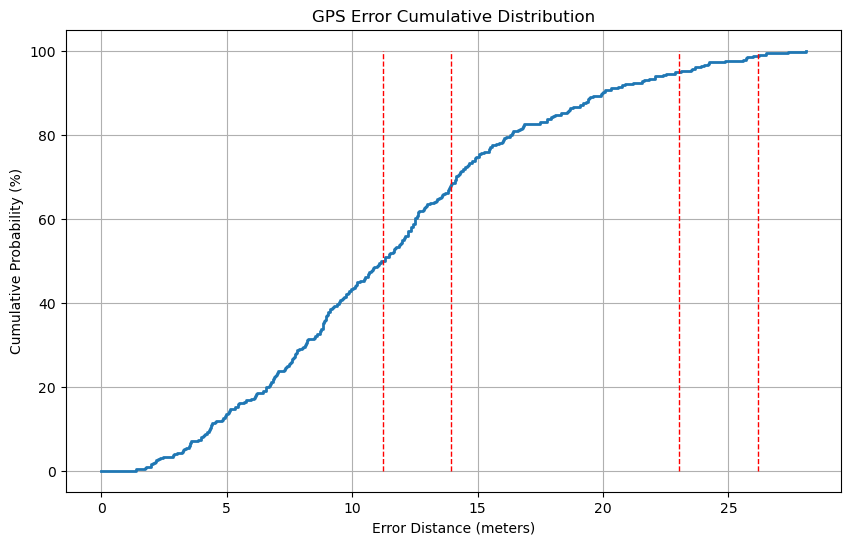

In [25]:
plt.figure(figsize=(10, 6), num='GPS Error CDF')
x = np.sort(all_errors)
n = len(x)
f = np.arange(1, n + 1) / n 

x0 = np.concatenate(([0], x))
f0 = np.concatenate(([0], f))

plt.step(x0, f0 * 100, where='post', linewidth=2, label='CDF')

# Добавление линий процентилей
for p, xl in zip(percentiles, percentile_vals):
    plt.plot([xl, xl], [0, 100], 'r--', linewidth=1)
    # ... добавление меток ...

plt.xlabel('Error Distance (meters)')
plt.ylabel('Cumulative Probability (%)')
plt.title('GPS Error Cumulative Distribution')
plt.grid(True)
plt.show()

In [5]:
# --- 1.1: Импорт библиотек и функция Haversine ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import warnings

def haversine_m(lat1, lon1, lat2, lon2):
    """Вычисляет расстояние между двумя GPS-точками по формуле Гаверсинуса (в метрах)."""
    R = 6371000  # Радиус Земли в метрах
    dLat = np.deg2rad(lat2 - lat1)
    dLon = np.deg2rad(lon2 - lon1)
    
    a = np.sin(dLat / 2.0)**2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(dLon / 2.0)**2
    a = np.clip(a, 0, 1) 
    d = 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return d

# --- 1.2: Параметры и Загрузка ---
csv_file = 'C:/Medical Waste/Маршруты Taraz схема.csv'
gap_min = 15     # Минимальный разрыв (в минутах) между поездками
min_pts = 3      # Минимальное количество точек в стационарном кластере
v_thr = 1.0      # Порог скорости для стационарности (м/с)
step_thr = 5.0   # Порог дистанции шага для стационарности (м)

try:
    T = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Ошибка: файл '{csv_file}' не найден.")
    exit()

# --- 1.3: Идентификация столбцов и Формирование DataFrame 'data' (ИСПРАВЛЕНО) ---
original_names = T.columns.tolist()
lower_names = [name.lower() for name in original_names]
name_map = dict(zip(lower_names, original_names)) # Словарь: нижний регистр -> оригинальное имя

# Функция для поиска оригинального имени столбца по ключевым словам
def find_original_column(keywords):
    for keyword in keywords:
        for lower_name in lower_names:
            if keyword in lower_name:
                return name_map[lower_name]
    return None

col_map = {
    'latitude': find_original_column(['latitude', 'lat']),
    'longitude': find_original_column(['longitude', 'lon', 'lng']),
    'timestamp': find_original_column(['timestamp', 'createdat', 'updatedat', 'time']),
    'speed': find_original_column(['speed', 'velocity']),
    'deviceid': find_original_column(['deviceid', 'device', 'device_id'])
}

data = pd.DataFrame()
try:
    # Используем найденные оригинальные имена
    data['latitude'] = T[col_map['latitude']]
    data['longitude'] = T[col_map['longitude']]
    data['timestamp'] = pd.to_datetime(T[col_map['timestamp']], utc=True, errors='coerce')
except TypeError:
    raise AssertionError('CSV должен содержать столбцы широты, долготы и временной метки.')

dev_col_name = col_map['deviceid']
if dev_col_name:
    data['deviceId'] = T[dev_col_name].astype(str)
else:
    data['deviceId'] = 'DEVICE-1' # Используем дефолтное имя, если devId не найдено

spd_col_name = col_map['speed']
if spd_col_name:
    spd = T[spd_col_name].astype(float).copy()
    valid_spd = spd.dropna()
    if not valid_spd.empty and valid_spd.median() < 20:
        spd *= 3.6  
    data['speed_kmh'] = spd
else:
    data['speed_kmh'] = np.nan

# Сортировка данных по устройству и времени
data = data.sort_values(by=['deviceId', 'timestamp']).reset_index(drop=True)

print(f"Шаг 1 завершен. Загружено точек: {len(data)}")

Шаг 1 завершен. Загружено точек: 8450


In [6]:
# --- 2.1: Расчет dt_s и trip_id ---
# Расчет разницы во времени (в секундах) в пределах каждого устройства
data['dt_s'] = data.groupby('deviceId')['timestamp'].diff().dt.total_seconds()

# Идентификация начала новой поездки
gap_threshold_s = gap_min * 60
new_trip = data['dt_s'].isna() | (data['dt_s'] > gap_threshold_s)

# Генерация trip_id через кумулятивную сумму
data['trip_id'] = new_trip.cumsum()
data['trip_id'] += data.groupby('deviceId')['trip_id'].transform('min') - 1 

# --- 2.2: Расчет stepDist_m и Заполнение Скорости ---
def calculate_step_dist(group):
    """Векторизованный расчет дистанции шага (stepDist_m) для каждой поездки."""
    lat1 = group['latitude'].shift(1)
    lon1 = group['longitude'].shift(1)
    lat2 = group['latitude']
    lon2 = group['longitude']
    
    distances = haversine_m(lat1, lon1, lat2, lon2)
    distances.iloc[0] = np.nan # Первая точка поездки
    return distances

data['stepDist_m'] = data.groupby('trip_id').apply(calculate_step_dist).reset_index(level=0, drop=True)

# Заполнение NaN-скорости (если скорость не была предоставлена)
nan_speed = data['speed_kmh'].isna()
if nan_speed.any():
    # Скорость = дистанция / время (конвертация в км/ч)
    data.loc[nan_speed, 'speed_kmh'] = (data['stepDist_m'] / data['dt_s']) * 3.6

print(f"Шаг 2 завершен. Найдено уникальных поездок: {data['trip_id'].nunique()}")

Шаг 2 завершен. Найдено уникальных поездок: 10


C:\Users\user\AppData\Local\Temp\ipykernel_14020\1706710498.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['stepDist_m'] = data.groupby('trip_id').apply(calculate_step_dist).reset_index(level=0, drop=True)


In [7]:
# --- 3.1: Детекция Стационарных Пробегов (stationary_run_id) ---
# Определение стационарных точек
data['is_stationary_point'] = (data['speed_kmh'] < v_thr) | (data['stepDist_m'] <= step_thr)
data['stationary_run_id'] = -1

# Логика кластеризации (итерация по поездкам и устройствам)
run_id_counter = 0
unique_groups = data.groupby(['deviceId', 'trip_id']).groups

for group_key, indices in unique_groups.items():
    idx = data.loc[indices].index 
    
    run_start = np.nan
    run_count = 0
    
    for k in idx:
        if data.loc[k, 'is_stationary_point']:
            if np.isnan(run_start): 
                run_start = k
                run_count = 1
            else:
                run_count += 1
        else:
            if not np.isnan(run_start) and run_count >= min_pts:
                run_id_counter += 1
                data.loc[run_start:k-1, 'stationary_run_id'] = run_id_counter
            
            run_start = np.nan
            run_count = 0
            
    # Обработка последнего сегмента
    if not np.isnan(run_start) and run_count >= min_pts:
        run_id_counter += 1
        data.loc[run_start:k, 'stationary_run_id'] = run_id_counter

# --- 3.2: Расчет Ошибок и Сбор Статистики ---
valid_runs = data['stationary_run_id'] >= 0
err_all = []
cluster_stats = []
cid_list = data.loc[valid_runs, 'stationary_run_id'].unique()

for cid in cid_list:
    subset = data[data['stationary_run_id'] == cid]
    if subset.empty: continue

    lat = subset['latitude'].values
    lon = subset['longitude'].values
    
    lat0 = np.mean(lat)
    lon0 = np.mean(lon)
    
    # Расчет ошибок
    errs = haversine_m(lat0, lon0, lat, lon)

    # Сохранение статистики кластера
    cs = {
        'cluster_id': int(cid),
        'trip_id': subset['trip_id'].mode().iloc[0],
        'deviceId': subset['deviceId'].iloc[0],
        'point_count': len(lat),
        'mean_error': np.mean(errs),
        'max_error': np.max(errs),
        'std_dev': np.std(errs)
    }
    cluster_stats.append(cs)
    err_all.extend(errs.tolist())

err_all = np.array(err_all)

if err_all.size == 0:
    print('Шаг 3 завершен. Ошибка: Не найдено стационарных кластеров. Настройте пороги или minPts.')
    exit()

print(f"Шаг 3 завершен. Найдено кластеров: {len(cid_list)}, всего точек для анализа: {len(err_all)}")

Шаг 3 завершен. Найдено кластеров: 22, всего точек для анализа: 335



GPS Error Statistics (all stationary points):
  Mean: 11.52 m | Max: 28.08 m | Std: 5.94 m
  CEP50: 11.05 m | P68: 13.90 m | P95: 22.96 m | P99: 26.15 m

Gaussian Check (within mean + kσ):
  1σ: 83.0% | 2σ: 95.2% | 3σ: 100.0%

Cluster Details (First 5):
Cluster  Trip     Points       MeanErr      MaxErr      
1        1        22           11.67        20.07       
2        1        10           11.15        24.01       
3        1        29           13.23        26.50       
4        3        7            11.05        25.70       
5        5        11           13.95        25.99       

ESP Device (stationary clusters):
  CEP50: 11.05 m | P95: 22.96 m
  Category: Basic Smartphone GPS

Шаг 4 завершен. Все графики отображаются.


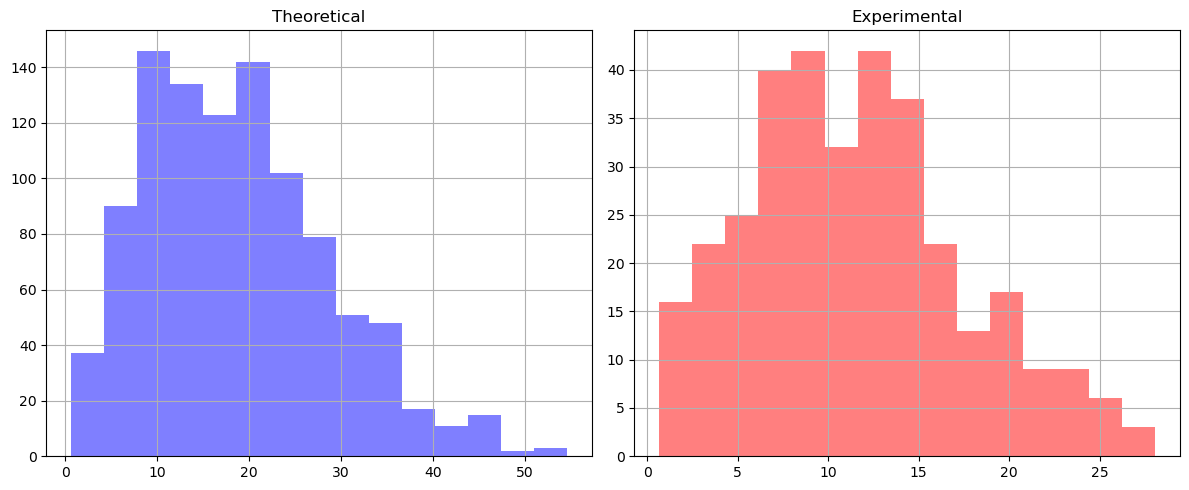

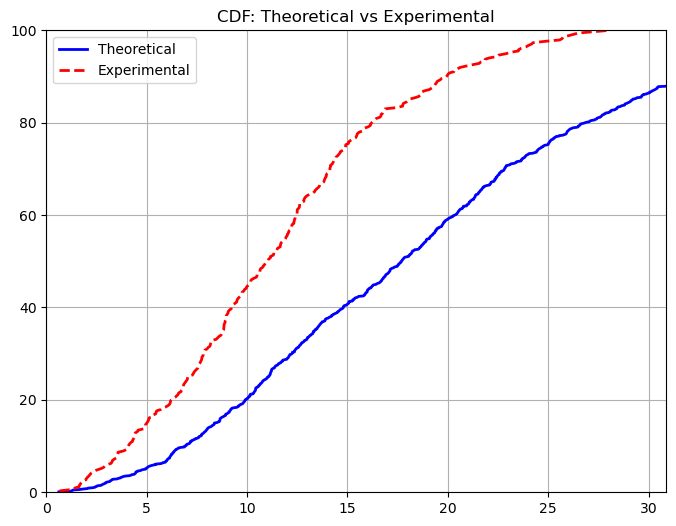

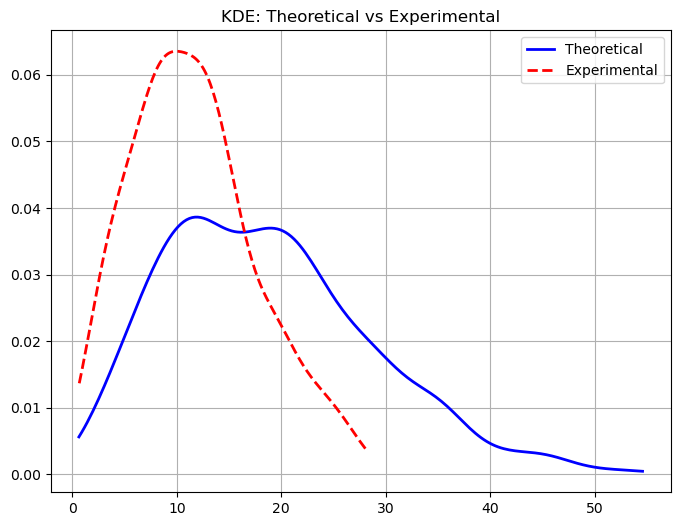

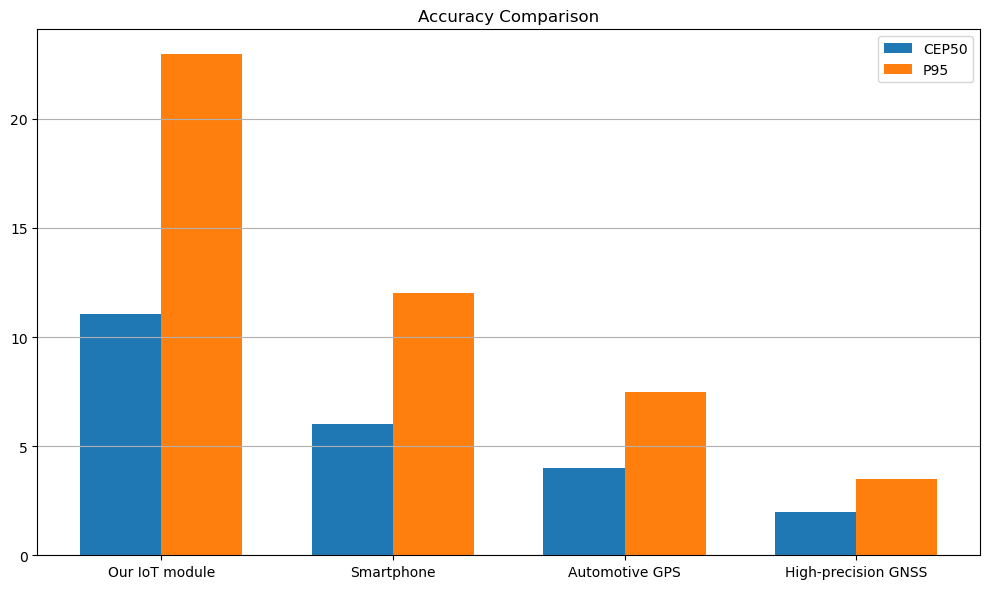

In [8]:
# --- 4.1: Общие Статистики и Процентили ---
m_err = np.mean(err_all)
x_err = np.max(err_all)
s_err = np.std(err_all)
pct = [50, 68, 95, 99]
pv = np.percentile(err_all, pct)

print('\nGPS Error Statistics (all stationary points):')
print(f'  Mean: {m_err:.2f} m | Max: {x_err:.2f} m | Std: {s_err:.2f} m')
print(f'  CEP50: {pv[0]:.2f} m | P68: {pv[1]:.2f} m | P95: {pv[2]:.2f} m | P99: {pv[3]:.2f} m')

# Гауссов Тест
w1 = np.mean(err_all <= (m_err + s_err)) * 100
w2 = np.mean(err_all <= (m_err + 2*s_err)) * 100
w3 = np.mean(err_all <= (m_err + 3*s_err)) * 100
print('\nGaussian Check (within mean + kσ):')
print(f'  1σ: {w1:.1f}% | 2σ: {w2:.1f}% | 3σ: {w3:.1f}%')

# --- 4.2: Визуализация (Гист., CDF, KDE, Bar Chart) ---

# Генерируем теоретические данные для сравнения
n_points = 1000
sigma_urban = 15
noise_urban = sigma_urban * np.random.randn(n_points, 2)
error_urban = np.sqrt(np.sum(noise_urban**2, axis=1)) # Рэлеевское распределение (расстояние)

# Figure 4: Гистограммы
fig4, axes4 = plt.subplots(1, 2, figsize=(12, 5), num='Figure 4: Error Histograms')
axes4[0].hist(error_urban, bins=15, color='blue', alpha=0.5); axes4[0].set_title('Theoretical'); axes4[0].grid(True)
axes4[1].hist(err_all, bins=15, color='red', alpha=0.5); axes4[1].set_title('Experimental'); axes4[1].grid(True)
plt.tight_layout()

# Figure 5: CDF
fig5, ax5 = plt.subplots(figsize=(8, 6), num='Figure 5: CDF')
st = np.sort(error_urban); ct = np.arange(1, len(st) + 1) / len(st) * 100
se = np.sort(err_all); ce = np.arange(1, len(se) + 1) / len(se) * 100
ax5.plot(st, ct, 'b-', linewidth=2, label='Theoretical');
ax5.plot(se, ce, 'r--', linewidth=2, label='Experimental');
ax5.set_title('CDF: Theoretical vs Experimental'); ax5.legend(); ax5.grid(True)
ax5.set_xlim(0, max(25, np.max(se) * 1.10) if se.size > 0 else 25); ax5.set_ylim(0, 100)

# Figure 6: KDE (Оценка Плотности Ядра)
fig6, ax6 = plt.subplots(figsize=(8, 6), num='Figure 6: KDE')
# Теоретический KDE
if error_urban.size > 1:
    kde_theo = gaussian_kde(error_urban); xi_theo = np.linspace(np.min(error_urban), np.max(error_urban), 200)
    ax6.plot(xi_theo, kde_theo(xi_theo), 'b-', linewidth=2, label='Theoretical')
# Экспериментальный KDE
if err_all.size > 1:
    kde_exp = gaussian_kde(err_all); xi_exp = np.linspace(np.min(err_all), np.max(err_all), 200)
    ax6.plot(xi_exp, kde_exp(xi_exp), 'r--', linewidth=2, label='Experimental')
ax6.set_title('KDE: Theoretical vs Experimental'); ax6.legend(); ax6.grid(True)

# Figure 7: Сравнение точности (Bar Chart)
fig7, ax7 = plt.subplots(figsize=(10, 6), num='Figure 7: Accuracy Comparison')
models = ['Our IoT module', 'Smartphone', 'Automotive GPS', 'High-precision GNSS']
cep_values = [np.percentile(err_all, 50), 6, 4, 2]
p95_values = [np.percentile(err_all, 95), 12, 7.5, 3.5]
data_to_plot = np.array([cep_values, p95_values]).T
x = np.arange(len(models)); width = 0.35
ax7.bar(x - width/2, data_to_plot[:, 0], width, label='CEP50')
ax7.bar(x + width/2, data_to_plot[:, 1], width, label='P95')
ax7.set_xticks(x); ax7.set_xticklabels(models); ax7.set_title('Accuracy Comparison'); ax7.legend(); ax7.grid(axis='y')
plt.tight_layout()


# --- 4.3: Финальный Отчет и Категоризация ---
cep50_now = np.percentile(err_all, 50)
if cep50_now <= 3:
    cat = 'High-precision GNSS'
elif cep50_now <= 5:
    cat = 'Typical Automotive GPS'
else:
    cat = 'Basic Smartphone GPS'

print('\nCluster Details (First 5):')
print(f"{'Cluster':<8} {'Trip':<8} {'Points':<12} {'MeanErr':<12} {'MaxErr':<12}")
for cs in cluster_stats[:5]:
    print(f"{cs['cluster_id']:<8} {cs['trip_id']:<8} {cs['point_count']:<12} {cs['mean_error']:<12.2f} {cs['max_error']:<12.2f}")

print('\nESP Device (stationary clusters):')
print(f'  CEP50: {cep50_now:.2f} m | P95: {np.percentile(err_all, 95):.2f} m')
print(f'  Category: {cat}')
print('\nШаг 4 завершен. Все графики отображаются.')

plt.show()

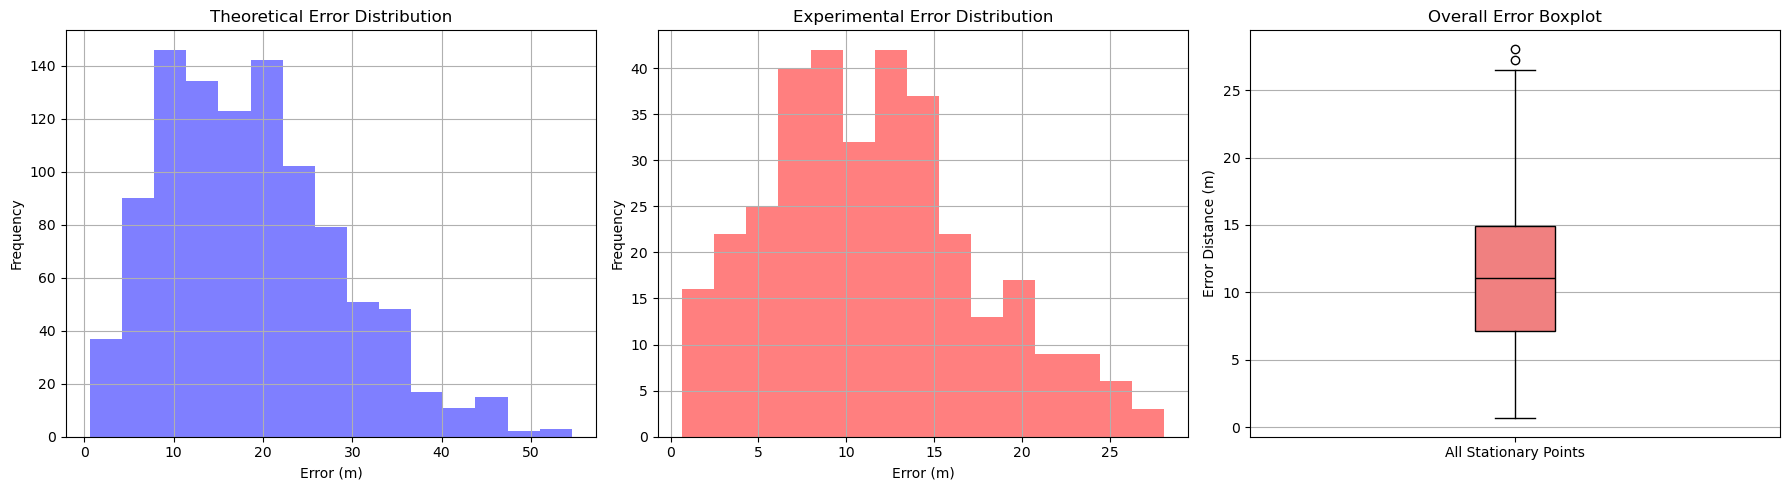

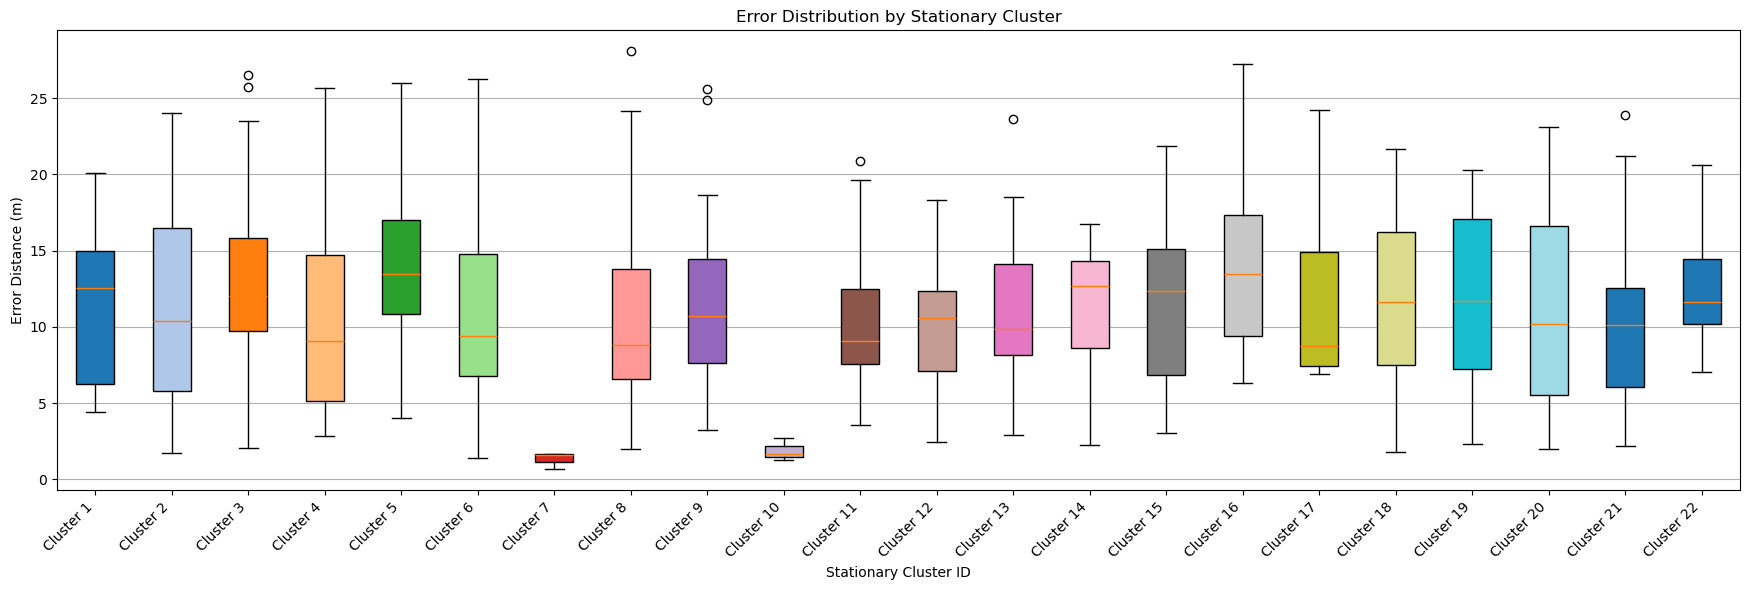

In [9]:
# --- 4.1, 4.2: Общие Статистики и Процентили и Визуализация (Начало) ---
# ... (Оставьте код 4.1 и 4.2 до раздела Figure 4) ...

# Figure 4: Гистограммы (Теоретическая vs Экспериментальная)
# Изменим Figure 4, чтобы добавить боксплот общего распределения ошибок.
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5), num='Figure 4: Error Distribution')

# Теоретическая гистограмма (Остается как axes4[0])
h1 = axes4[0].hist(error_urban, bins=15, color='blue', alpha=0.5, edgecolor='none')
axes4[0].set_title('Theoretical Error Distribution')
axes4[0].set_xlabel('Error (m)')
axes4[0].set_ylabel('Frequency')
axes4[0].grid(True)

# Экспериментальная гистограмма (Остается как axes4[1])
h2 = axes4[1].hist(err_all, bins=15, color='red', alpha=0.5, edgecolor='none')
axes4[1].set_title('Experimental Error Distribution')
axes4[1].set_xlabel('Error (m)')
axes4[1].set_ylabel('Frequency')
axes4[1].grid(True)

# НОВЫЙ КОД: Боксплот общего распределения ошибок (axes4[2])
axes4[2].boxplot(err_all, vert=True, patch_artist=True, 
                 boxprops=dict(facecolor='lightcoral'), 
                 medianprops=dict(color='black'))
axes4[2].set_title('Overall Error Boxplot')
axes4[2].set_ylabel('Error Distance (m)')
axes4[2].set_xticks([1])
axes4[2].set_xticklabels(['All Stationary Points'])
axes4[2].grid(axis='y')

plt.tight_layout()

# ... (Код для Figure 5, Figure 6, Figure 7 остается без изменений) ...


# --- 4.4: НОВЫЙ ГРАФИК: Боксплоты по Кластерам (Figure 8) ---

# Шаг 1: Сбор ошибок по кластерам
cluster_error_data = []
cluster_labels = []

# Пересобираем ошибки из исходного DataFrame 'data'
# (Это более чистый способ, чем собирать во время цикла в Шаге 3)
for cid in cid_list:
    subset = data[data['stationary_run_id'] == cid]
    if subset.empty: continue
    
    lat = subset['latitude'].values
    lon = subset['longitude'].values
    lat0 = np.mean(lat)
    lon0 = np.mean(lon)
    errs = haversine_m(lat0, lon0, lat, lon)
    
    cluster_error_data.append(errs)
    cluster_labels.append(f"Cluster {int(cid)}")

if cluster_error_data:
    fig8, ax8 = plt.subplots(figsize=(max(12, len(cluster_error_data) * 0.8), 6), num='Figure 8: Cluster Error Distribution (Boxplots)')
    
    # Построение боксплотов
    bp = ax8.boxplot(cluster_error_data, vert=True, patch_artist=True)
    
    # Настройка цветов (опционально)
    colors = plt.cm.tab20.colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax8.set_xticks(np.arange(1, len(cluster_labels) + 1))
    ax8.set_xticklabels(cluster_labels, rotation=45, ha="right")
    ax8.set_ylabel('Error Distance (m)')
    ax8.set_xlabel('Stationary Cluster ID')
    ax8.set_title('Error Distribution by Stationary Cluster')
    ax8.grid(axis='y')

plt.tight_layout()
# --- Конец новых графиков ---

# ... (Оставьте код 4.3 и 4.4 (Вывод Отчета) без изменений) ...

plt.show()